A linear predictors is a linear function (linear combination) of a set of coefficients and explanatory variables (independent variables), whose value is used to predict the outcome of a dependent variable.

Many learning algorithms rely on linear predictors. Moreover, linear predictors are intuitive, easy to inerpret and fit the data reasonably well in many natural learning problems

Linera predictors are besd on the class of affine functions

$$ L_d = \{\mathbf x \mapsto \langle\mathbf w, \mathbf x\rangle + b:\mathbf w \in \mathbb R^d, b \in \mathbb R\} $$

Each function $h_{\mathbf w,b}$ is parametrized by a vector $\mathbf w$ that define a linear transformation and a scalar $b$ that define a translation.
Usually the term $b$, called *bias* is incorporated into $\mathbf w$ as an extra coordinate, adding also an extra coordinate with value 1 to all $\mathbf x \in \mathcal X$

$$ \mathbf w' =\begin{pmatrix}b, w_1, \ldots, w_d\end{pmatrix} \qquad \mathbf x' = \begin{pmatrix}1, x_1, \ldots, x_d\end{pmatrix}$$

## Halfspaces

A function $h_{\mathbf w,b}$ defines an hyperplane in the space $\mathbb R$ that divide this into two subsapces called *half-spaces*. The hypothesis class of halfspaces is designed for binary classification problems, namely $\mathcal X=\mathbb R^d$ and $\mathcal Y =\{-1,+1\}$. The class of half-spaces is defined as follows:

$$ HS_d = \text{sign}\circ L_d = \{\mathbf x \mapsto \text{sign}(h_{\mathbf w,b}(\mathbf x)) : h_{\mathbf w,b} \in L_d\}$$

Consider the 2-dimensional case. Each hypothesis define an hyperplane that is perpendicular to the vector $\mathbf w$ and separates the space into two sub-spaces:

- the points *above* the hyperplane (that share an acute angle with $\mathbf w$) are labeled positively
- the points *below* the hyperplane (that share an obtuse angle with $\mathbf w$) are labeled negatively

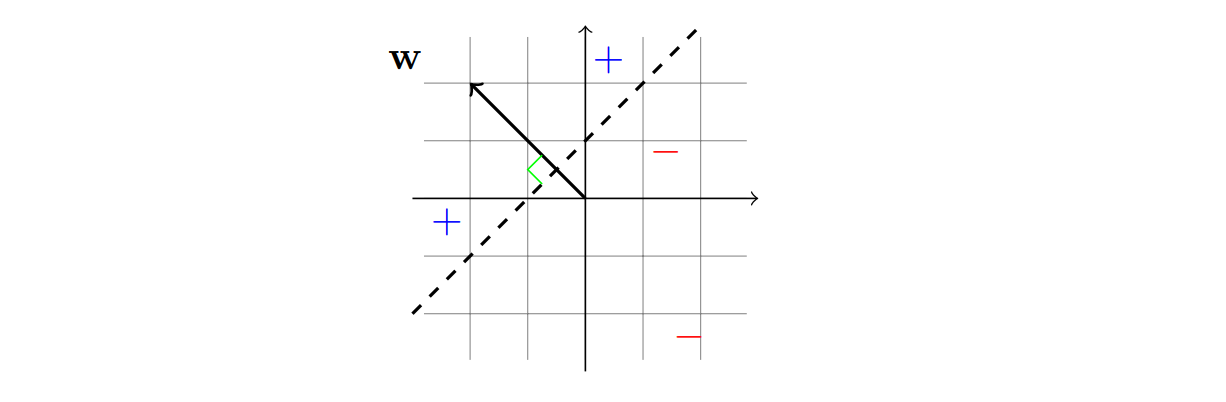

In the condition of **realizability assumption** (namely the points of the two classes are linearly separable), the ERM problem for halfspaces can be expressed as a linear program, that is an optimization problem of a *linear function* under *linear constraints*.

Let $S = \{(\mathbf x_i, y_i)\}_{i=1}^m$ be a training set of size $m$. From the realizability assumption follows that an ERM predictor should have zero errors on the training set. Or equivalently that exists at least a vector $\mathbf w^*$ such that:

$$ \text{sign}(\langle\mathbf w^*, \mathbf x_i\rangle) = y_i,\qquad \forall i = 1, \ldots, m$$

Considering the closest point to the hyperplane $\gamma = \min_i(y_i\langle\mathbf w^*, \mathbf x_i\rangle)$ we can define the vector $\mathbf{\bar w} = \frac{\mathbf w^*}{\gamma} $. Therefore foreach $i$:

$$ y_i\langle\mathbf{\bar w}, \mathbf x_i\rangle = \frac{1}{\gamma}y_i\langle\mathbf w^*, \mathbf x_i\rangle = \frac{y_i\langle\mathbf w^*, \mathbf x_i\rangle}{\min_i(y_i\langle\mathbf w^*, \mathbf x_i\rangle)} \ge 1 $$

Letting $A\in\mathbb R ^{m\times d}$ be the matrix whose elements are defined as $A_{i,j} = y_ix_{i,j}$ and letting $\mathbf v = \begin{pmatrix} 1, 1, \ldots,1\end{pmatrix}\in\mathbb R^m$, the equation above can be rewritten as a linear program:

$$ A\mathbf w \ge \mathbf v $$

Note that since all the vectors that satisfy this constraint are euqally good candidates, we can set a dummy objective $u = \begin{pmatrix} 0,0,\ldots,0\end{pmatrix}\in\mathbb R^d$

### Code implementation

We start generating the set of samples $S = \{(\mathbf x_i, y_i)\}_{i=1}^m$. In this case we will consider a simple set of 20 2D points. Remeber that we need to assure realizability assumption, namely that the points of the two classes are linearly separable, in order to make the magic happen. I have defined a separating line $y = 2*x + 5$ and then generated ten points of the class $"+"$ (above the line) and ten points of the class $"-"$ (below the line)

In [5]:
def generate_2Dlinearly_separable_data(slope, intercept, n_pos=10, n_neg=10, rng=None):

    if rng is None:
        rng = np.random.default_rng()
        
    separating_line = lambda x: slope*x + intercept
    
    x_pos = np.array([(x - 15*rng.random(), separating_line(x) + 15*rng.random()) for x in rng.integers(-5, 5, n_pos)])
    x_neg = np.array([(x + 15*rng.random(), separating_line(x) - 15*rng.random())for x in rng.integers(-5, 5, n_neg)])
    
    return np.vstack((x_pos, x_neg))

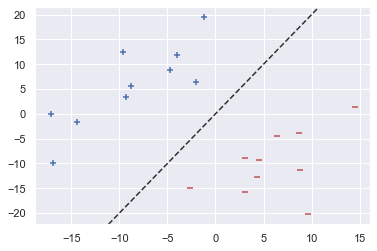

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

rng = np.random.default_rng(27)  # set random generator
n_pos = 10
n_neg = 10
slope = 2
intercept = 0

X = generate_2Dlinearly_separable_data(slope, intercept, n_pos, n_neg, rng = rng)     # creating points
y = np.ones(n_pos + n_neg)                                                            # creating labels
y[n_pos:] *= -1

# plotting separated data
plt.scatter(*zip(*X[:n_pos]), c='b', marker='+')
plt.scatter(*zip(*X[n_pos:]), c='r', marker='_')
plt.axline((0, intercept), slope = slope,  linestyle='--', color='black', alpha=0.8, label ='current')

To perform the computation of an halfspace I will make advantage of the LP library PuLP. First of all I define the set of points $X = \{\mathbf x_i = (x_{i,1}, x_{i,2})\}_{i=1}^m$ and the set of labels $y = \{y_i\}_{i=1}^m$. Then I define the dummy vector $u$ the matrix $A$ as defined above. There is no need to explicitly define the constraint vector $v$ since the constraints will be added one at a time.

In [7]:
from pulp import *  

u = np.zeros(2)
A = X *y[:,np.newaxis]
# v = np.ones(len(X))*1.0

# Create the model
model = LpProblem(name="small-problem", sense=LpMaximize)

# Initialize the decision variables
# bias = LpVariable(name="bias", lowBound=-10)
x1 = LpVariable(name="x1", lowBound=-10)
x2 = LpVariable(name="x2", lowBound=-10)

# Adding constraints Aw > v
for i in range(len(A)):
    model += (A[i][0]*x1 + A[i][1]*x2 >= 1, f"{i}-constraints")

# model += A @ (x, y) >= [1] * len(A)
obj_func = 1.0*x1 + 1.0*x2
model += obj_func

In [8]:
model

small-problem:
MAXIMIZE
1.0*x1 + 1.0*x2 + 0.0
SUBJECT TO
0_constraints: - 16.845009699 x1 - 9.8497131406 x2 >= 1

1_constraints: - 1.9839982578 x1 + 6.39670540154 x2 >= 1

2_constraints: - 17.1512356745 x1 + 0.0515558287691 x2 >= 1

3_constraints: - 4.72724144852 x1 + 8.90581868517 x2 >= 1

4_constraints: - 9.60605220313 x1 + 12.5262196315 x2 >= 1

5_constraints: - 9.32797156358 x1 + 3.30328564249 x2 >= 1

6_constraints: - 4.02513169913 x1 + 11.8413360552 x2 >= 1

7_constraints: - 8.76259841519 x1 + 5.70600968139 x2 >= 1

8_constraints: - 14.4274077437 x1 - 1.56023579825 x2 >= 1

9_constraints: - 1.17369863842 x1 + 19.5556585708 x2 >= 1

10_constraints: - 4.53520123796 x1 + 9.2326153341 x2 >= 1

11_constraints: - 14.49917292 x1 - 1.37757671719 x2 >= 1

12_constraints: - 8.82547775394 x1 + 11.3520165391 x2 >= 1

13_constraints: 2.6592223496 x1 + 14.968585771 x2 >= 1

14_constraints: - 6.41187013184 x1 + 4.39248982626 x2 >= 1

15_constraints: - 3.08223032132 x1 + 8.92019403811 x2 >= 1

1

In [9]:
status = model.solve()
print(f"Completed successfully: {status == 1}")

Completed successfully: True


Finally to test the results of the model, we can retrieve the computed normal vector $w$ that defines the computed separating hyperplane, compute the predicted labels as <code>np.sign(X @ w)</code> and plot the results. As we can see the model is perfectly able to find a possible separating hyperplane.

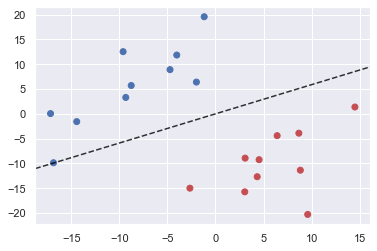

In [11]:
w = np.array([model.variables()[0].value(), model.variables()[1].value()])
y_pred = np.sign(X @ w)

colors = ['b' if y == 1.0 else 'r' for y in y_pred ]
plt.scatter(X[:,0], X[:,1], c=colors)

d = -w[0]/w[1]
plt.axline((0, 0), slope = d,  linestyle='--', color='black', alpha=0.8, label ='current')

## Perceptron

Perceptron is a linear predictor based on an iterative algorithm. At the beginning the vector $\mathbf w^{(0)}$ is initialized randomly. Then, at each iteration $t$, the Perceptron finds an example $i$ that is mislabeled by $\mathbf w^{(t)}$ or mathematically a sample $\mathbf x_i$ such that $\text{sign}(\langle\mathbf w^{(t)}, \mathbf x_i\rangle)\neq y_i$ and updates it current vector as:

$$\mathbf w^{(t+1)} =\mathbf w^{(t)} + y_i\mathbf x_i $$

What this update practically does is to move the boundary in the direction of $\mathbf x_i$ in order to make a correct prediction on this sample

<img src='https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/images/Perceptron/PerceptronUpdate.png'>

In [12]:
class Perceptron():
    def __show_update(self, X, y, i):
        pos_mask = y == 1
        neg_mask = y == -1
        
        # plot points
        plt.scatter(X[pos_mask, 0], X[pos_mask, 1], c='b', marker='+')
        plt.scatter(X[neg_mask, 0], X[neg_mask, 1], c='r', marker='_')
        plt.scatter(X[i, 0], X[i, 1], c='g', marker='o')
        
        # plot new separating line
        current_w = self.w
        d = -current_w[1] / (current_w[2] or np.inf)
        plt.axline((0, current_w[0]), slope = d,  linestyle='--', color='black', alpha=0.8, label ='current')
        
        # plot old separating line
        old_w = self.w - y[i] * np.insert(X[i], 0, 1)
        d = -old_w[1] / (old_w[2] or np.inf)
        plt.axline((0,old_w[0]), slope = d,linestyle='--', color='gray', alpha=0.8, label ='old')
        
        plt.legend()
        plt.show()

    def train(self, X, y, w=None, rng = None):
        m, n = X.shape
        self.w = np.random.rand(n + 1)   # initialize random normal vector

        while True:
            stop_flag = True
            
            # iterate on points
            for i in range(m):
                x = np.insert(X[i], 0, 1)
                
                # if point misclassified -> update
                if y[i] * (self.w @ x) <= 0:
                    self.w = self.w + y[i] * x
                    stop_flag = False
                    self.__show_update(X, y, i)

            # if all points are correctly classified return
            if stop_flag:
                return

    def predict(self, X):
        return np.sign(np.hstack((np.ones(X.shape[0])[:, np.newaxis], X)) @ self.w)

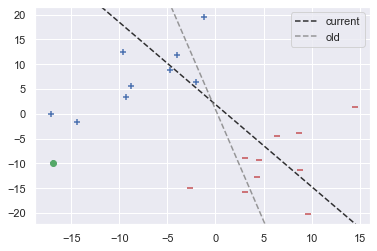

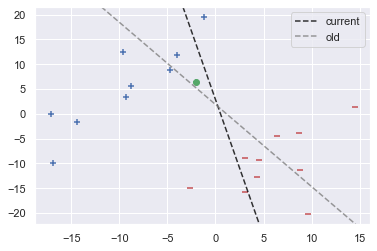

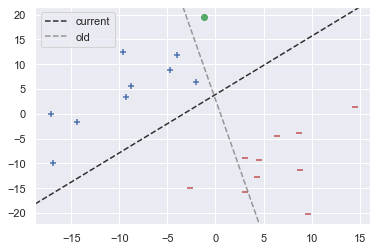

In [13]:
model = Perceptron()
model.train(X, y)

In [ ]:
y_pred = model.predict(X)
colors = ['b' if y == 1.0 else 'r' for y in y_pred ]
plt.scatter(X[:,0], X[:,1], c=colors)
# plt.plot([-10,10], [separating_line(-10), separating_line(10)],  linestyle='--', color ='black')
d = -model.w[1]/model.w[2]
plt.axline((0, model.w[0]), slope = d,  linestyle='--', color='black', alpha=0.8, label ='current')
        

In [ ]:
status